In [7]:
class KalmanFilter(object):
    def __init__(self, dt, u, std_acc, std_meas):
        self.dt = dt
        self.u = u
        self.std_acc = std_acc
        self.A = np.matrix([[1, self.dt],
                            [0, 1]])
        self.B = np.matrix([[(self.dt**2)/2], [self.dt]]) 
        self.H = np.matrix([[1,0]])
        self.Q = np.matrix([[(self.dt**4)/4, (self.dt**3)/2],
                            [(self.dt**3)/2, self.dt**2]]) * self.std_acc**2
        self.R = std_meas**2
        self.P = np.eye(self.A.shape[1])
        self.x = np.matrix([[0],[0]])
    
    def predict(self):
        # Ref :Eq.(9) and Eq.(10)
        # Update time state
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)
        # Calculate error covariance
        # P= A*P*A' + Q
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x
    
    def update(self, z):
        # Ref :Eq.(11) , Eq.(11) and Eq.(13)
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        # Calculate the Kalman Gain
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  # Eq.(11)
        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))  # Eq.(12)
        I = np.eye(self.H.shape[1])
        self.P = (I - (K * self.H)) * self.P  # Eq.(13)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [65]:
def main():
    dt = 0.1
    t = np.arange(0, 100, dt)
    # Define a model track
    Fs = 44100
    real_track = 10*np.sin(2**np.pi*Fs*t)+5*np.random.normal(-1,1,len(t))
    u= 1
    std_acc = 1     # we assume that the standard deviation of the acceleration is 0.25 (m/s^2)
    std_meas = 1    # and standard deviation of the measurement is 1.2 (m)
    # create KalmanFilter object
    kf = KalmanFilter(dt, u, std_acc, std_meas)
    predictions = []
    measurements = []
    for x in real_track:
        # Mesurement
        z = kf.H * x + np.random.normal(0, 50)
        measurements.append(z.item(0))
        predictions.append(kf.predict()[0])
        kf.update(z.item(0))
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Example of Kalman filter for tracking a moving object in 1-D', fontsize=20)
    plt.plot(t, measurements, label='Measurements', color='b',linewidth=0.5)
    plt.plot(t, np.array(real_track), label='Real Track', color='y', linewidth=1.5)
    plt.plot(t, np.squeeze(predictions), label='Kalman Filter Prediction', color='r', linewidth=1.5)
    plt.xlabel('Time (s)', fontsize=20)
    plt.ylabel('Position (m)', fontsize=20)
    plt.legend()
    plt.show()

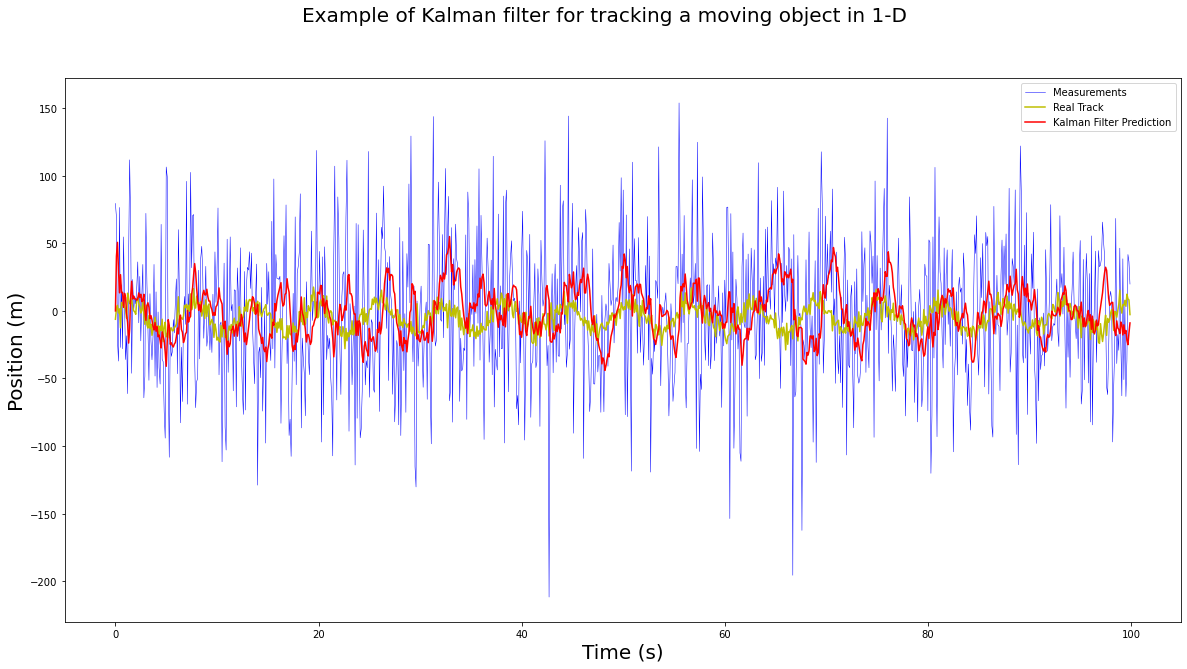

In [66]:
main()

In [59]:
dt = 0.1
t = np.arange(0, 100, dt)
# Define a model track
Fs = 44100
real_track = 10*np.sin(2**np.pi*Fs*t)+noise

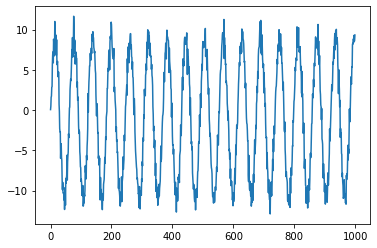

In [60]:
plt.plot(real_track)

In [58]:
noise = np.random.normal(-1,1,len(real_track))

In [109]:
import numpy as np
from scipy.optimize import curve_fit

def denoise(data):

    def oavar(data, rate, numpoints=30):

        x = np.cumsum(data)

        max_ratio = 1/9
        num_points = 30
        ms = np.unique(
            np.logspace(0, np.log10(len(x) * max_ratio), numpoints
           ).astype(int))        

        oavars = np.empty(len(ms))
        for i, m in enumerate(ms):
            oavars[i] = (
                (x[2*m:] - 2*x[m:-m] + x[:-2*m])**2
            ).mean() / (2*m**2)

        return ms / rate, oavars

    def ln_NKfit(ln_tau, ln_N, ln_K):
        tau = np.exp(ln_tau)
        N, K = np.exp([ln_N, ln_K])
        oadev = N**2 / tau + K**2 * (tau/3)
        return np.log(oadev)

    def get_NK(data, rate):
        taus, oavars = oavar(data, rate)

        ln_params, ln_varmatrix = (
            curve_fit(ln_NKfit, np.log(taus), np.log(oavars))
        )
        return np.exp(ln_params)    

    # Initialize state and uncertainty
    state = data[0]
    output = np.empty(len(data))

    rate = 10 # We can set this to 1, if we're calculating N, K internally
    # N and K will just be scaled relative to the sampling rate internally
    dt = 1/rate

    N, K = get_NK(data, rate)

    process_noise = K**2 * dt
    measurement_noise = N**2 / dt

    covariance = measurement_noise

    for index, measurement in enumerate(data):
        # 1. Predict state using system's model

        covariance += process_noise

        # Update
        kalman_gain = covariance / (covariance + measurement_noise)

        state += kalman_gain * (measurement - state)
        covariance = (1 - kalman_gain) * covariance

        output[index] = state

    return output

In [111]:
denoised_output = denoise(real_track)

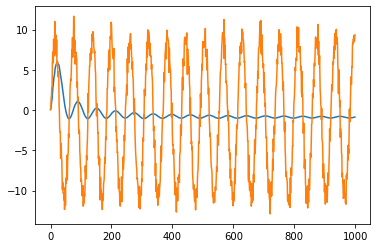

In [113]:
plt.plot(denoised_output)
plt.plot(real_track)
plt.show()

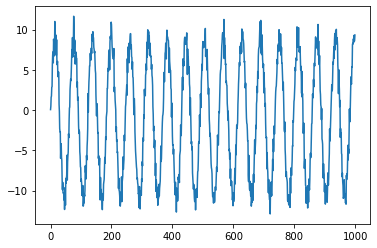

In [72]:
plt.plot(real_track)

In [77]:
import numpy as np


def kalman(x, d, N = 64, sgm2v=1e-4):
    nIters = min(len(x),len(d)) - N
    u = np.zeros(N)
    w = np.zeros(N)
    Q = np.eye(N)*sgm2v
    P = np.eye(N)*sgm2v
    I = np.eye(N)
    e = np.zeros(nIters)
    for n in range(nIters):
        u[1:] = u[:-1]
        u[0] = x[n]
        e_n =  d[n] - np.dot(u, w)
        R = e_n**2+1e-10
        Pn = P + Q
        r = np.dot(Pn,u)
        K = r / (np.dot(u, r) + R + 1e-10)
        w = w + np.dot(K, e_n)
        P = np.dot(I - np.outer(K, u), Pn)
        e[n] = e_n

    return e

In [102]:
observation_matrix.shape

(1, 2)

started loop
ended loop
[False False False False False  True False False False False False]
[[0.2]
 [0.23]
 [0.3]
 [0.4]
 [0.5]
 [--]
 [0.65]
 [0.67]
 [0.62]
 [0.5]
 [0.4]]


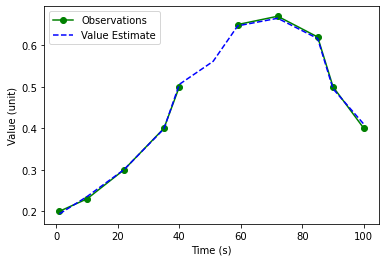

In [108]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import copy

outlier_thresh = 0.95

# Treat y as position, and that y-dot is
# an unobserved state - the velocity,
# which is modelled as changing slowly (inertia)

# state vector [y,
#               y_dot]

# transition_matrix =  [[1, dt],
#                       [0, 1]]

observation_matrix = np.asarray([[1, 0]])

# observations:
t = [1,10,22,35,40,51,59,72,85,90,100]

# dt betweeen observations:
dt = [np.mean(np.diff(t))] + list(np.diff(t))
transition_matrices = np.asarray([[[1, each_dt],[0, 1]]
                                    for each_dt in dt])

# observations
y = np.transpose(np.asarray([[0.2,0.23,0.3,0.4,0.5,0.2,
                              0.65,0.67,0.62,0.5,0.4]]))

y = np.ma.array(y)


leave_1_out_cov = []
print("started loop")
for i in range(len(y)):
    y_masked = np.ma.array(copy.deepcopy(y))
    y_masked[i] = np.ma.masked

    kf1 = KalmanFilter(transition_matrices = transition_matrices,
                   observation_matrices = observation_matrix)

    kf1 = kf1.em(y_masked)

    leave_1_out_cov.append(kf1.observation_covariance[0,0])
print("ended loop")
# Find indexes that contributed excessively to observation covariance
outliers = (leave_1_out_cov / np.mean(leave_1_out_cov)) < outlier_thresh

print(outliers)

for i in range(len(outliers)):
    if outliers[i]:
        y[i] = np.ma.masked

print(y)

kf1 = KalmanFilter(transition_matrices = transition_matrices,
                   observation_matrices = observation_matrix)

kf1 = kf1.em(y)

(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(y)


plt.figure()
plt.plot(t, y, 'go-', label="Observations")
plt.plot(t, smoothed_state_means[:,0], 'b--', label="Value Estimate" )
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Value (unit)")

plt.show()

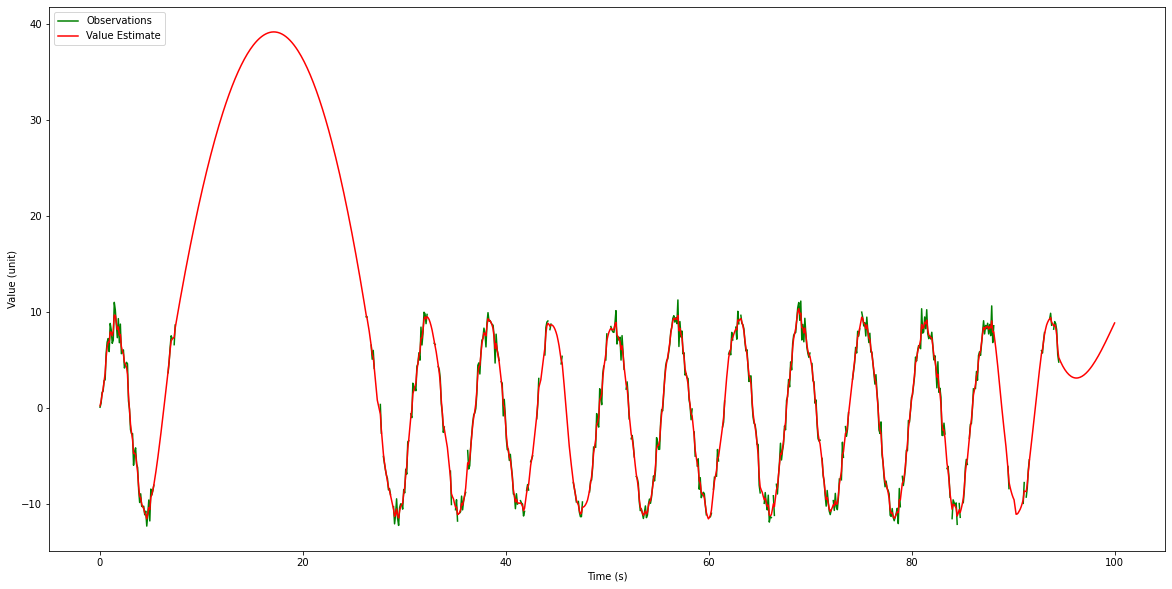

In [104]:
plt.figure(figsize=(20,10))
plt.plot(t, y, 'g', label="Observations")
plt.plot(t, smoothed_state_means[:,0], 'r', label="Value Estimate" )
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Value (unit)")

plt.show()

In [220]:
import numpy as np


def kalman(x, d, N = 64, sgm2v=1e-4):
    nIters = min(len(x),len(d)) - N
    u = np.zeros(N)
    w = np.zeros(N)
    Q = np.eye(N)*sgm2v
    P = np.eye(N)*sgm2v
    I = np.eye(N)
    e = np.zeros(nIters)
    for n in range(nIters):
        u[1:] = u[:-1]
        u[0] = x[n]
        e_n = d[n] - np.dot(u, w)
        e[n] = np.dot(u, w)
        R = e_n**2+1e-10
        Pn = P + Q
        r = np.dot(Pn,u)
        K = r / (np.dot(u, r) + R + 1e-10)
        w = w + np.dot(K, e_n)
        P = np.dot(I - np.outer(K, u), Pn)
    return e

In [221]:
dt = 0.1
t = np.arange(0, 100, dt)
# Define a model track
Fs = 44100
d = 10*np.sin(2**np.pi*Fs*t)
x = 10*np.sin(2**np.pi*Fs*t)+noise

ret = kalman(x, d, 8)

ValueError: operands could not be broadcast together with shapes (1000,) (10000,) 

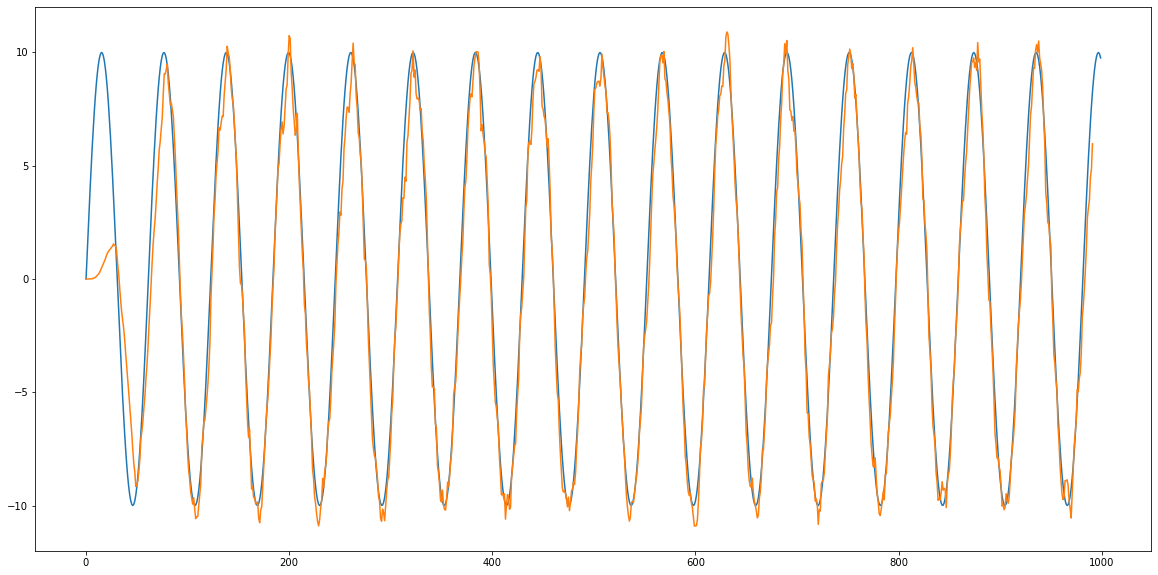

In [197]:
# plt.plot(x)
plt.plot(d)
plt.plot(ret)

In [163]:
ret = ret/max(ret)

In [207]:
np.dot([1, 1], [1,1])

2

In [226]:
from scipy.io import wavfile
samplerate, data = wavfile.read('./test.wav')

In [227]:
wavfile.write("gen.wav",44100,ret/max(ret))

In [172]:
wavfile.write("noi.wav",44100,x/max(x))

In [156]:
ret = np.array(ret, dtype=np.float32)

In [228]:
d = data[:44100*30,0]

In [229]:
x = d + 1000*np.random.normal(-1,1,len(d))

In [141]:
plt.rcParams['figure.figsize'] = (20,10)

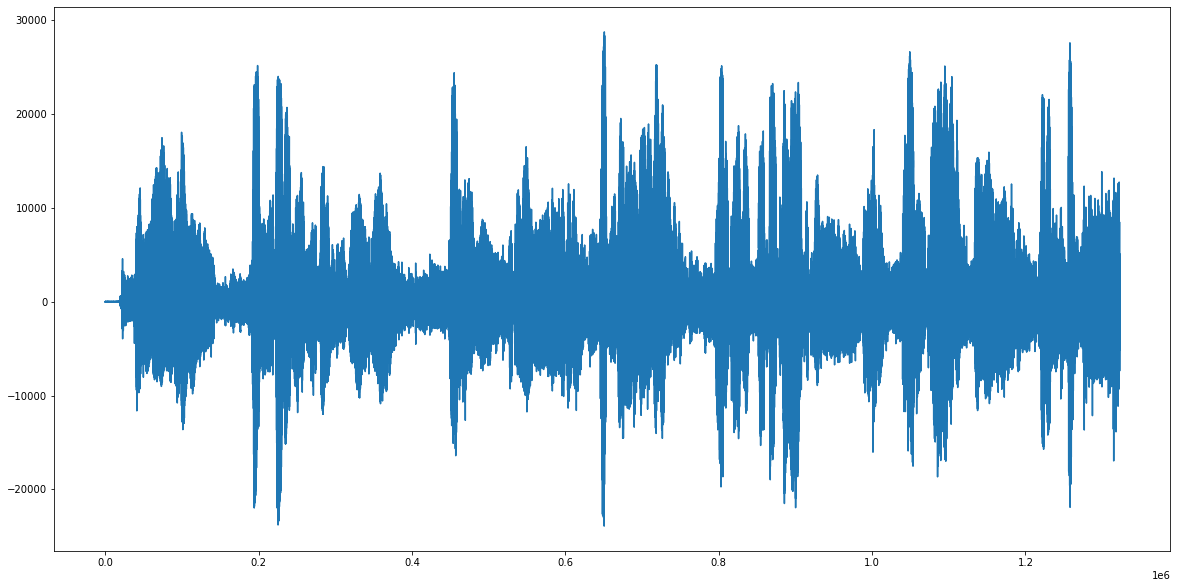

In [147]:
plt.plot(x)

In [166]:
x = x/max(x)

In [247]:
import numpy as np
from numpy.fft import rfft as fft
from numpy.fft import irfft as ifft

def fdkf(x, d, M, beta=0.9, sgm2u=1e-2, sgm2v=1e-6):
    Q = sgm2u
    R = np.full(M+1,sgm2v)
    H = np.zeros(M+1,dtype=np.complex)
    P = np.full(M+1,sgm2u)

    window =  np.hanning(M)
    x_old = np.zeros(M)

    num_block = min(len(x),len(d)) // M
    e = np.zeros(num_block*M)

    for n in range(num_block):
        x_n = np.concatenate([x_old,x[n*M:(n+1)*M]])
        d_n = d[n*M:(n+1)*M]
        x_old = x[n*M:(n+1)*M]

        X_n = np.fft.rfft(x_n)

        y_n = ifft(H*X_n)[M:]
        e_n = d_n-y_n

        e_fft = np.concatenate([np.zeros(M),e_n*window])
        E_n = fft(e_fft)

        R = beta*R + (1.0 - beta)*(np.abs(E_n)**2)
        P_n = P + Q*(np.abs(H))
        K = P_n*X_n.conj()/(X_n*P_n*X_n.conj()+R)
        P = (1.0 - K*X_n)*P_n 

        H = H + K*E_n
        h = ifft(H)
        h[M:] = 0
        H = fft(h)

        e[n*M:(n+1)*M] = e_n
  
    return e

In [248]:
dt = 0.1
t = np.arange(0, 1000, dt)
# Define a model track
Fs = 44100
d = 10*np.sin(2**np.pi*Fs*t)
noise = np.random.normal(-1,1,len(d))
x = 10*np.sin(2**np.pi*Fs*t)+noise

ret = fdkf(x, d, 64)

/var/folders/jr/f2jcthz95pl7fq_94vdr9jdh0000gn/T/ipykernel_4613/2612542418.py:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  H = np.zeros(M+1,dtype=np.complex)


/var/folders/jr/f2jcthz95pl7fq_94vdr9jdh0000gn/T/ipykernel_4613/2612542418.py:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  H = np.zeros(M+1,dtype=np.complex)


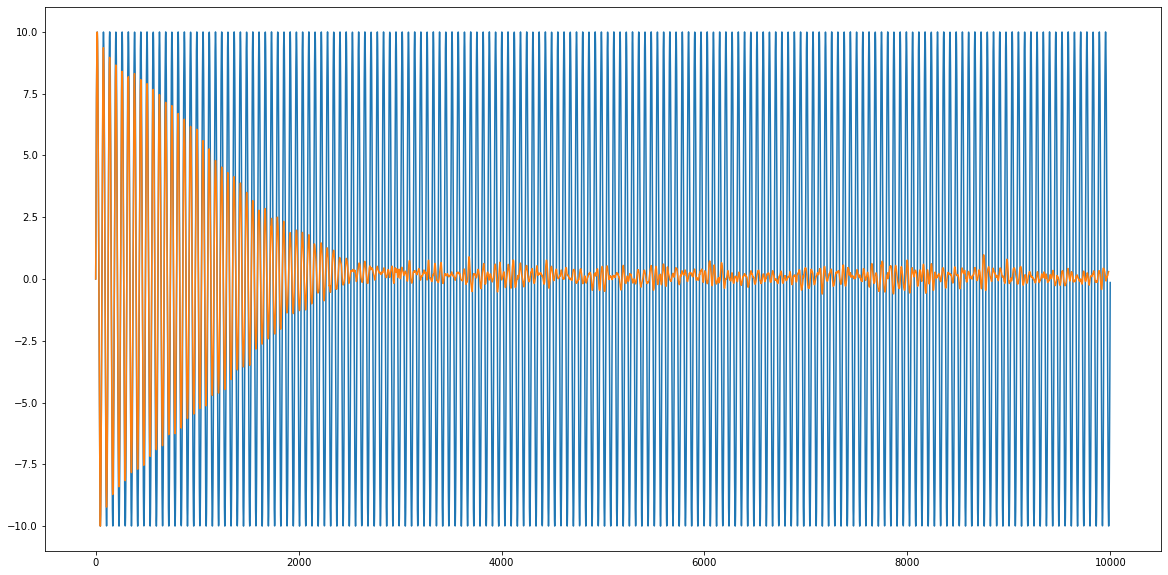

In [249]:
ret = fdkf(x, d, 64)
plt.plot(d)
plt.plot(ret)

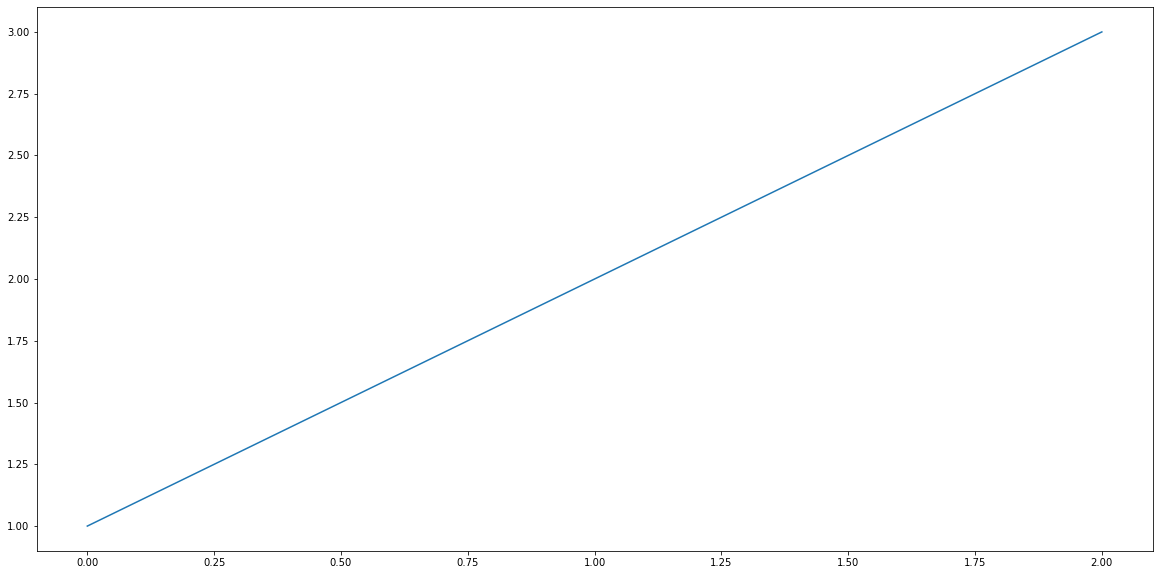

In [250]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

plt.plot([1,2,3])
plt.savefig('/tmp/test.png')

In [252]:
import numpy as np

a = np.linspace(-1,1,50)
b = np.concatenate([a, a, a, a])

In [253]:
a,b

(array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
        -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
        -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
        -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
        -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
         0.02040816,  0.06122449,  0.10204082,  0.14285714,  0.18367347,
         0.2244898 ,  0.26530612,  0.30612245,  0.34693878,  0.3877551 ,
         0.42857143,  0.46938776,  0.51020408,  0.55102041,  0.59183673,
         0.63265306,  0.67346939,  0.71428571,  0.75510204,  0.79591837,
         0.83673469,  0.87755102,  0.91836735,  0.95918367,  1.        ]),
 array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
        -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
        -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
        -0.3877551 , -0.34693878, -0.30612245, -0

In [262]:
v = []
for i in range(0, len(b)-50):
    v.append(np.correlate(a, b[i:i+50]))

/var/folders/jr/f2jcthz95pl7fq_94vdr9jdh0000gn/T/ipykernel_4613/159845518.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/var/folders/jr/f2jcthz95pl7fq_94vdr9jdh0000gn/T/ipykernel_4613/159845518.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


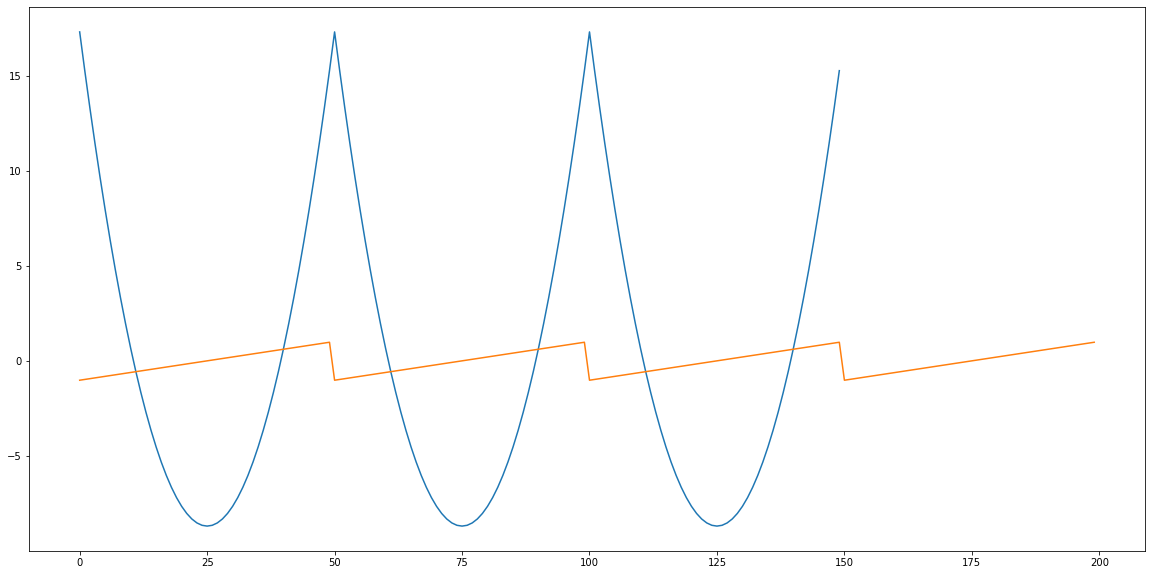

In [265]:
plt.plot(v)
plt.show()
plt.plot(b)
plt.show()